In [2]:
import pandas_datareader.data as web
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras import models, layers, optimizers
import math

In [5]:
start = datetime.today() - timedelta(370*5)
end = datetime.today() - timedelta(1)
df = web.DataReader('F', 'iex', start, end)

stock = df.loc[:,'open']
num = len(stock[10:-1])
stock_full = stock
stock = stock[10:-1]
print(num)

#x = np.arange(num)/num
#x = x.reshape(-1, 1)
#y = stock

scaler = MinMaxScaler()
y = np.array(stock).reshape(len(stock), 1)

scaler = scaler.fit(y)
y = scaler.transform(y)
y = y.reshape(len(stock))

# create x: [[10 prices]...[10 prices]]
x = [[None]]*num
for i in range(num):
    x[i] = np.array(stock_full[i:i+10]).reshape(10,1)
    x[i] = scaler.transform(x[i])
    x[i] = x[i].reshape(10)
#x = np.transpose(np.array(x))
x = np.array(x)

#shuffle_indices = np.random.permutation(np.arange(len(y)))
#y = y[shuffle_indices]
#x = x[shuffle_indices]

print(len(x))
print(type(x))
print(x, y)

#print(x.shape, y.shape)

network = models.Sequential()
network.add(layers.Dense(256, activation='relu', input_shape=(10,)))
network.add(layers.Dense(256, activation='relu'))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(128, activation='relu'))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(64, activation='relu'))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dense(32, activation='relu'))
network.add(layers.Dense(16, activation='relu'))
network.add(layers.Dense(16, activation='relu'))
network.add(layers.Dense(1))



1247
1247
<class 'numpy.ndarray'>
[[0.8375231  0.81274049 0.83882834 ... 0.82057193 0.78928008 0.77102368]
 [0.81274049 0.83882834 0.84664282 ... 0.78928008 0.77102368 0.77102368]
 [0.83882834 0.84664282 0.8375231  ... 0.77102368 0.77102368 0.74754632]
 ...
 [0.20456664 0.21812757 0.2418592  ... 0.24694455 0.22490804 0.18761548]
 [0.21812757 0.2418592  0.23846897 ... 0.22490804 0.18761548 0.14354245]
 [0.2418592  0.23846897 0.20456664 ... 0.18761548 0.14354245 0.15710339]] [0.77102368 0.74754632 0.76190395 ... 0.14354245 0.15710339 0.1486278 ]


In [6]:
network.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
history = network.fit(x, y, epochs=50, batch_size=125)

Epoch 1/50
1247/1247 [==============================] - 1s 608us/step - loss: 0.1245 - mean_squared_error: 0.1245
Epoch 2/50
1247/1247 [==============================] - 0s 48us/step - loss: 0.0171 - mean_squared_error: 0.0171
Epoch 3/50
1247/1247 [==============================] - 0s 59us/step - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 4/50
1247/1247 [==============================] - 0s 48us/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 5/50
1247/1247 [==============================] - 0s 50us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 6/50
1247/1247 [==============================] - 0s 56us/step - loss: 0.0036 - mean_squared_error: 0.0036
Epoch 7/50
1247/1247 [==============================] - 0s 52us/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 8/50
1247/1247 [==============================] - 0s 51us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 9/50
1247/1247 [==============================] - 0s 57us/step - loss: 0.0014 - mean_squa

0


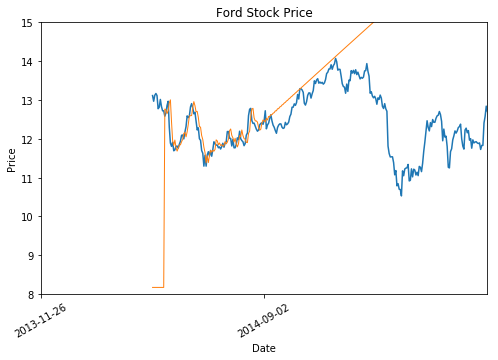

200


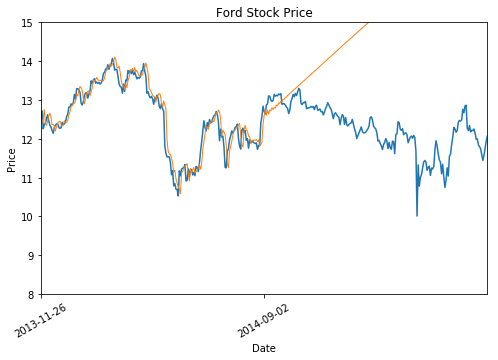

400


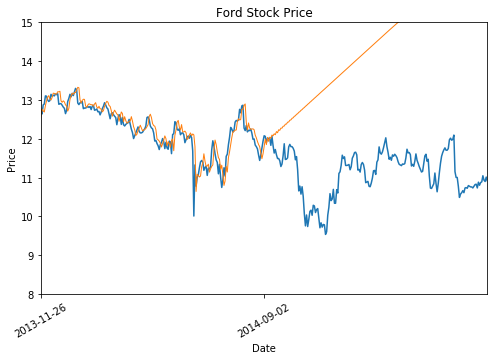

600


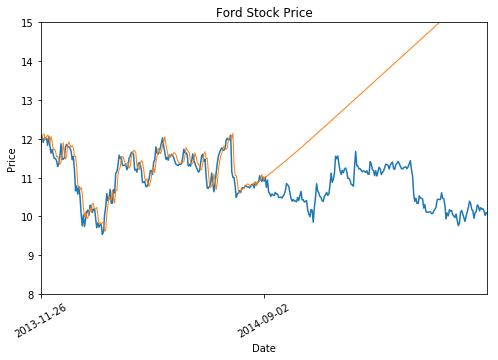

800


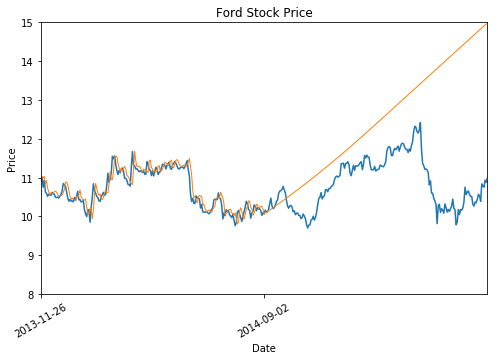

1000


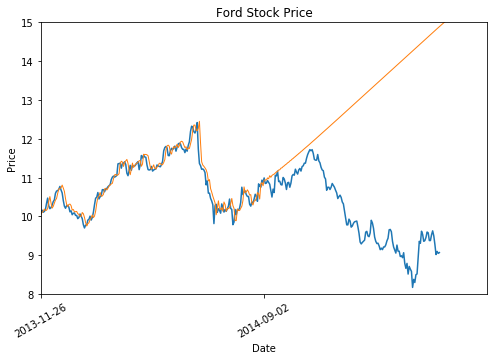

In [9]:
# New clean version
# orig: raw stock data, pred: predicted data
def plot(orig, pred, xstep=200, ymin=8, ymax=15, xmin=0, xmax=1500, line=-1):
    base = datetime.strptime(df.index[0], '%Y-%m-%d')
    xlabels = [(base + timedelta(days=xstep*x*7/5)).date() for x in range(0, math.ceil((xmax-xmin)/xstep))]
    
    plt.figure(figsize=(8,5))
    plt.plot(np.arange(0, len(orig)), orig)
    plt.plot(np.arange(0, len(pred)), pred, lw=1)
    
    if(line != -1):
        plt.plot(line, ymin, line, ymax, color='red', lw=1)
        print(line)
    
    plt.xlabel('Date')
    plt.xticks(np.arange(xmin, xmax, step=xstep), xlabels, rotation=30)
    plt.ylabel('Price')
    plt.ylim(ymin, ymax)
    plt.xlim(xmin, xmax)
    plt.title('Ford Stock Price')
    plt.show()
    plt.close()
    
# make predictions
# orig: stock data, fun: prediction function
# n: number of predictions, early: number points before end of stock data to start predicting
# returns: array of predictions
def pred(orig, fun, scaler, n=100, early=0):
    # scale orig b/t 0 and 1, and put in np array
    orig = scaler.transform(np.array(orig).reshape(len(orig),1)).reshape(len(orig))
    
    # create space for final predictions
    p = np.zeros(len(orig) + n - early)
        
    # predict before breaking away (before early off of len(orig))
    for i in range(len(orig) - 9 - early):
        p[i+11] = fun(orig[i:i+10].reshape(1,10))
        
    # predict after breaking away (after early off of len(orig))
    for i in range(len(orig) - 9 - early, len(p) - 11):
        p[i+11] = fun(p[i:i+10].reshape(1,10))
    
    return scaler.inverse_transform(p.reshape(-1,1))
    
for i in range(len(stock_full) - 200, 0, -200):
    plot(stock_full, pred(stock_full, network.predict, scaler, early=100 + i, n=200), xmin=len(stock_full) - i - 300, xmax=len(stock_full)-i + 100, line=len(stock_full) - i - 200)